# 多层感知机

## 多层感知机

### 隐藏层

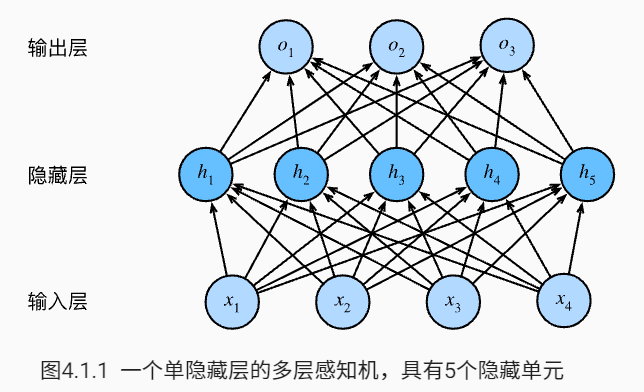

每个输入都会影响隐藏层中的每个神经元， 而隐藏层中的每个神经元又会影响输出层中的每个神经元。

#### 从线性到非线性

如果不加激活函数，不管加多少层，始终是线性模型。
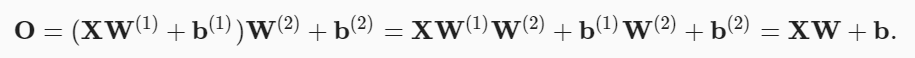

#### 通用近似定理

就算是只有一层隐藏层，只有神经元个数足够多以及权重正确，就可以拟合任何函数。但是更建议增加层数，更容易逼近许多函数。

### 激活函数

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

#### Relu函数

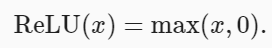

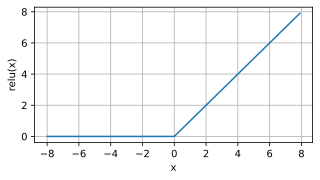

In [2]:
x = torch.arange(-8.0,8.0,0.1,requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(),y.detach(),'x','relu(x)',figsize=(5,2.5))

In [3]:
x.detach().type()

'torch.FloatTensor'

In [4]:
type(x.detach().numpy())

numpy.ndarray

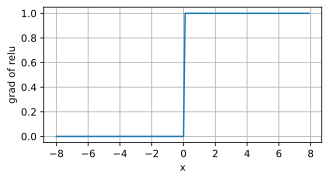

In [5]:
y.backward(torch.ones_like(x),retain_graph=True) 
# retain_graph的作用，假如两个层都公用一个神经网络的参数但是有两个loss的输出，因此需要retain_graph参数为True去保留中间参数从而两个loss的backward()不会相互影响。
d2l.plot(x.detach(),x.grad,'x','grad of relu',figsize=(5,2.5))

改进：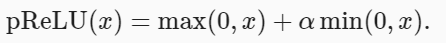

负值也能通过

#### sigmoid函数 

sigmoid:平滑，可导，阈值单元。

现在还常用来作二分类。

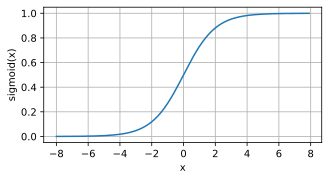

In [6]:
y = torch.sigmoid(x)
d2l.plot(x.detach(),y.detach(),'x','sigmoid(x)',figsize=(5,2.5))

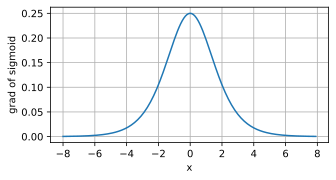

In [7]:
# sigmoid导数可视化
x.grad.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of sigmoid',figsize=(5,2.5))

#### tanh函数 

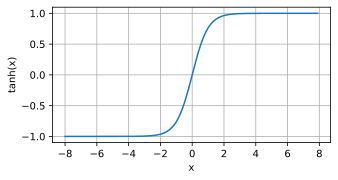

In [8]:
y = torch.tanh(x)
d2l.plot(x.detach(),y.detach(),'x','tanh(x)',figsize=(5,2.5))

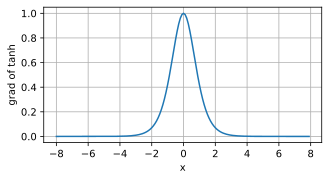

In [9]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

### 总结 

多层感知机在输出层和输入层之间增加一个或多个全连接隐藏层，并通过激活函数转换隐藏层的输出。

常用的激活函数包括ReLU函数、sigmoid函数和tanh函数。

## 多层感知机从零开始实现

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

C:\ProgramData\Anaconda3\envs\d21-zh\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 初始化模型参数 

In [11]:
num_inputs,num_outputs,num_hiddens = 784,10,256
# 一层隐藏层,不算输入层，共两层
# randn是标准正态分布
W1 = nn.Parameter(torch.randn(num_inputs,num_hiddens,requires_grad=True)*0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens,num_outputs,requires_grad=True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1,b1,W2,b2]

### 激活函数 

In [12]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X,a)

### 模型 

In [13]:
def net(X):
    X = X.reshape(-1,num_inputs)
    H = relu(X@W1+b1) # 这里“@”代表矩阵乘法
    return H@W2 + b2

### 损失函数

In [14]:
loss = nn.CrossEntropyLoss() # crossentropy loss input 为 (N,C)维

### 训练

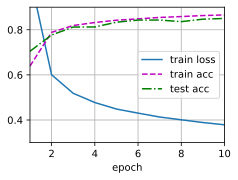

In [15]:
# 与softmax一模一样
num_epochs,lr = 10,0.1
updater = torch.optim.SGD(params,lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)

## 多层感知机简洁实现 

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

In [17]:
net = nn.Sequential(nn.Flatten(),
             nn.Linear(784,256),
             nn.ReLU(),
             nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

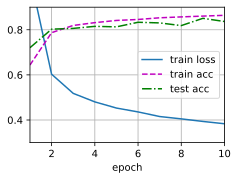

In [18]:
batch_size,lr,num_epochs = 256,0.1,10

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(),lr=lr)

train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 模型选择、欠拟合和过拟合

### 训练误差和泛化误差

训练集：训练误差
验证集：泛化误差

### 模型选择

在确定模型的超参数前，尽量不用到测试集，如果在模型选择阶段就用了测试集，容易过拟合。所以需要额外设置验证集。

在训练数据集有限的情况下，采取k-fold交叉验证，

### 过拟合或欠拟合

- 模型复杂度：模型参数数量，可解释性，表达能力。
- 数据量的大小。

做一个小实验，多项式模型预测，随着模型复杂度的变化，过拟合和欠拟合发生的状况。

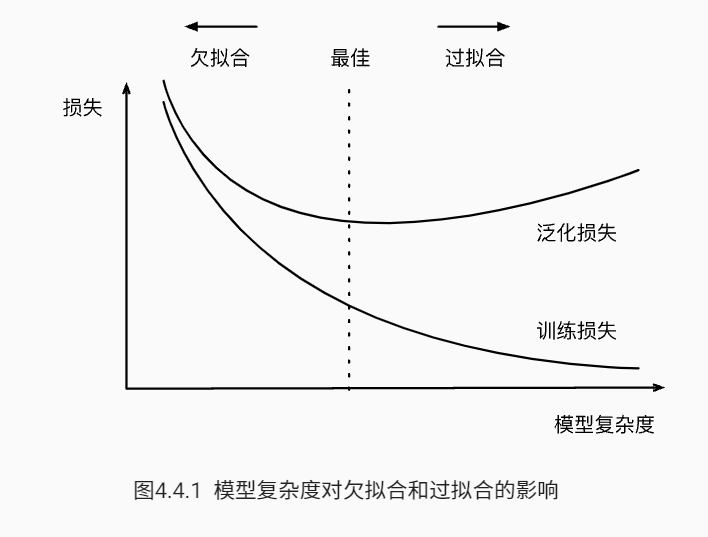

### 多项式回归

In [19]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

#### 生产数据集

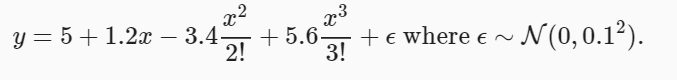

噪声项 ϵ 服从均值为0且标准差为0.1的正态分布。 在优化的过程中，我们通常希望避免非常大的梯度值或损失值。 这就是我们将特征从 xi 调整为 xii! 的原因， 这样可以避免很大的 i 带来的特别大的指数值。 我们将为训练集和测试集各生成100个样本。

In [20]:
max_degree = 20
n_train,n_test = 100,100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# poly_features维度：(n_train+n_test,max_degree)
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) # scale是标准差

In [21]:
# NumPyndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.1058],
         [-0.1503]]),
 tensor([[ 1.0000e+00,  1.0576e-01,  5.5925e-03,  1.9715e-04,  5.2126e-06,
           1.1026e-07,  1.9434e-09,  2.9362e-11,  3.8816e-13,  4.5613e-15,
           4.8239e-17,  4.6379e-19,  4.0875e-21,  3.3253e-23,  2.5120e-25,
           1.7711e-27,  1.1707e-29,  7.2830e-32,  4.2791e-34,  2.3819e-36],
         [ 1.0000e+00, -1.5032e-01,  1.1298e-02, -5.6609e-04,  2.1274e-05,
          -6.3956e-07,  1.6023e-08, -3.4408e-10,  6.4652e-12, -1.0798e-13,
           1.6232e-15, -2.2181e-17,  2.7786e-19, -3.2128e-21,  3.4496e-23,
          -3.4570e-25,  3.2478e-27, -2.8718e-29,  2.3982e-31, -1.8974e-33]]),
 tensor([5.2305, 4.8046]))

#### 对模型进行训练和测试

In [22]:
def evaluate_loss(net,data_iter,loss):
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric.data[0] / metric.data[1]

In [23]:
def train_epoch_ch3(net,train_iter,loss,updater): #@save
    # 将模型设置为训练模式
    if isinstance(net,torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            # torch.optim.Optimizer:优化权重的类，其他所有优化器都是它的基类
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])

In [24]:
# d2l.load_array
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none') # 均方误差；去掉reduction='none'，则默认取均值
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

#### 三阶多项式函数拟合(正态)

weight: [[ 5.001713   1.1930121 -3.3808045  5.624698 ]]


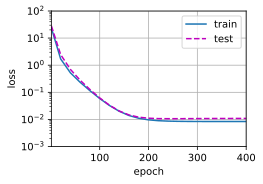

In [25]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!; 每一阶是一个新的特征
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

#### 线性函数拟合(欠拟合)

weight: [[3.3981714 3.8120782]]


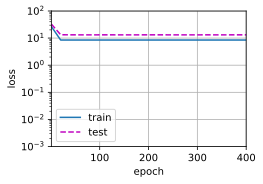

In [26]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

#### 高阶多项式函数拟合(过拟合)

weight: [[ 4.9914308e+00  1.2621932e+00 -3.3314548e+00  5.2022243e+00
  -1.2565005e-01  1.2174995e+00  1.0472395e-02  2.6743296e-01
   1.8027318e-03 -1.2538075e-01  1.6370058e-01  1.9582215e-01
  -9.8207146e-02  3.2015201e-02 -1.5700799e-01 -1.5113376e-01
   1.3037416e-01  5.5354625e-02 -1.6335486e-01 -1.9240762e-01]]


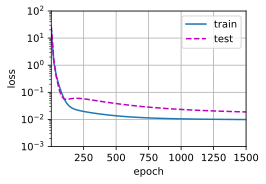

In [27]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

？我不理解，这怎么过拟合了，不是挺好的？？？

### 总结 

- 欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。

- 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，即防止泛化误差过大。

- 验证集可以用于模型选择，但不能过于随意地使用它。

- 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。

## 权重衰减 

限制特征的数量是缓解过拟合的一种常用技术。

权重衰减（weight decay）是最广泛使用的正则化的技术之一， 它通常也被称为 L2 正则化。

这项技术通过函数与零的距离来衡量函数的复杂度， 因为在所有函数 f 中，函数 f=0 （所有输入都得到值 0 ） 在某种意义上是最简单的。 但是我们应该如何精确地测量一个函数和零之间的距离呢？

一种简单的方法是通过线性函数  f(x)=w⊤x  中的权重向量的某个范数来度量其复杂性， 例如 ∥w∥2 。 要保证权重向量比较小， 最常用方法是将其范数作为惩罚项加到最小化损失的问题中。

> 矩阵范数：描述矩阵引起变化的大小.
向量范数：描述向量在空间中的大小。

### 高维线性回归

In [28]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

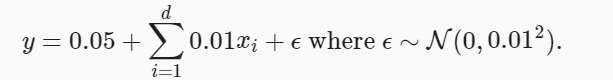

我们选择标签是关于输入的线性函数。 标签同时被均值为0，标准差为0.01高斯噪声破坏。 为了使过拟合的效果更加明显，我们可以将问题的维数增加到 d=200 ， 并使用一个只包含20个样本的小训练集。

In [29]:
n_train,n_test,num_inputs,batch_size = 20,100,200,5
true_w,true_b = torch.ones((num_inputs,1))*0.01,0.05
train_data = d2l.synthetic_data(true_w,true_b,n_train)
train_iter = d2l.load_array(train_data,batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 从零开始

从头开始实现权重衰减

#### 初始化模型参数

In [30]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

#### 定义L2范数惩罚

In [31]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

#### 定义训练代码

In [32]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

#### 忽略正则化直接训练

w的L2范数是： 13.604437828063965


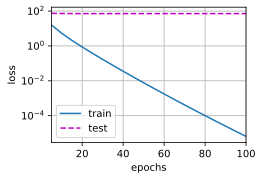

In [33]:
train(lambd=0)

#### 使用权重衰减

w的L2范数是： 0.35200047492980957


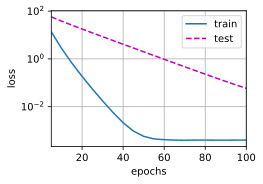

In [34]:
train(lambd=3)

### 简洁实现

深度学习框架为了便于我们使用权重衰减， 将权重衰减集成到优化算法中，以便与任何损失函数结合使用。 

In [35]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay':wd}, # 只给权重设置了衰减
        {"params":net[0].bias}],lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.710816383361816


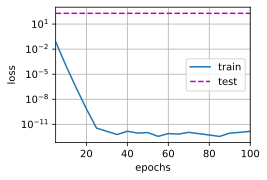

In [36]:
train_concise(0)

w的L2范数： 0.47422316670417786


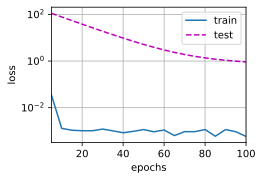

In [37]:
train_concise(3)

## 暂退法

### 实践中的暂退法

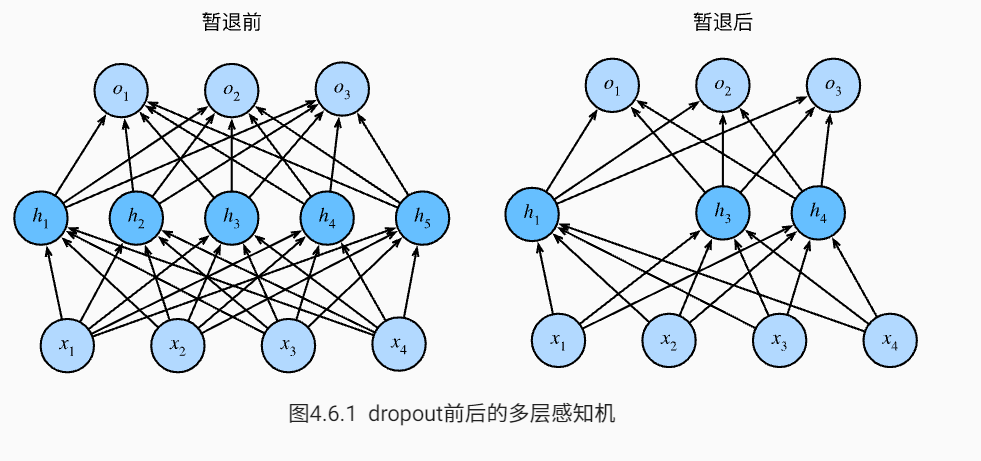

核心思想是：希望假如噪音（高斯分布）后，模型依然可以表现很好。

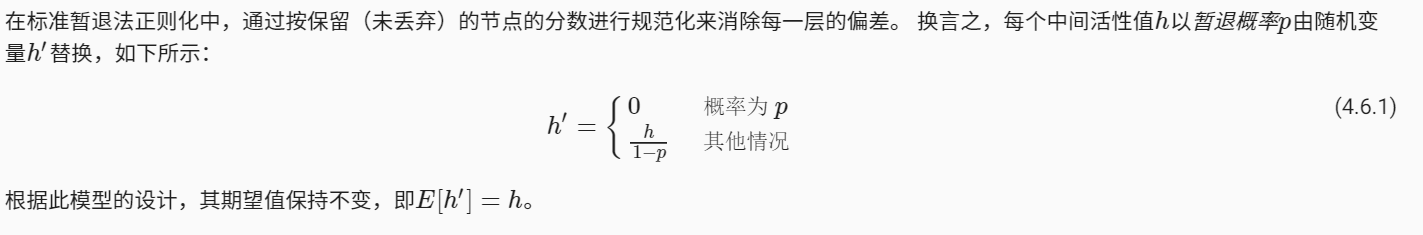

### 暂退法从零实现

In [38]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X,dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float() # 非零即1
    return mask*X / (1-dropout)

In [39]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  6.,  8.,  0., 12., 14.],
        [16.,  0.,  0.,  0.,  0.,  0., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


#### 定义模型参数

引入的Fashion-MNIST数据集。 我们定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元。

In [40]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

#### 定义模型

In [41]:
dropout1, dropout2 = 0.2, 0.5 # 一般输出是不设置dropout

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        
    # 前向传播
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

自己实现的Net类继承了nn.Module类，这是PyTorch中所有网络的父类。在nn.Module中有一个__call__()方法，它相当于C++中的重载()运算符，当我们执行 类名() 这种样式的语句时就会调用__call__()，而在该方法中就有调用forward()。在自定义Net类中我们def的forward()相当于重载了父类nn.Module中的forward()方法，同时自定义Net类也继承了父类的__call__()，因此在执行Net(input)这样的语句时Net类的__call__()被调用，连带着其中的forward()也被调用了，表现出来的就是使用Net(input)时forward()被运行。

#### 训练和测试

In [42]:
# m=nn.Linear(3, 4)
# print(m.weight)
# print(m.bias) 不为零

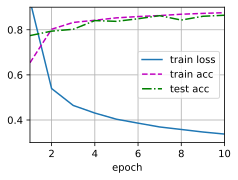

In [43]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 暂退法简洁实现

In [44]:
net = nn.Sequential(nn.Flatten(),
                   nn.Linear(784,256),
                   nn.ReLU(),
                   nn.Dropout(dropout1),
                   nn.Linear(256,256),
                   nn.ReLU(),
                   nn.Dropout(dropout2),
                   nn.Linear(256,10)
                   )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

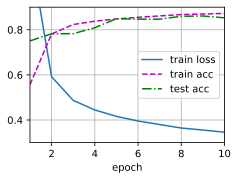

In [45]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

> 同时使用权重衰减和dropout效果可能反而会变差

## 前向传播、反向传播和计算图

到目前为止，我们只考虑了通过前向传播（forward propagation）所涉及的计算。 在计算梯度时，我们只调用了深度学习框架提供的反向传播函数，而不知其所以然。

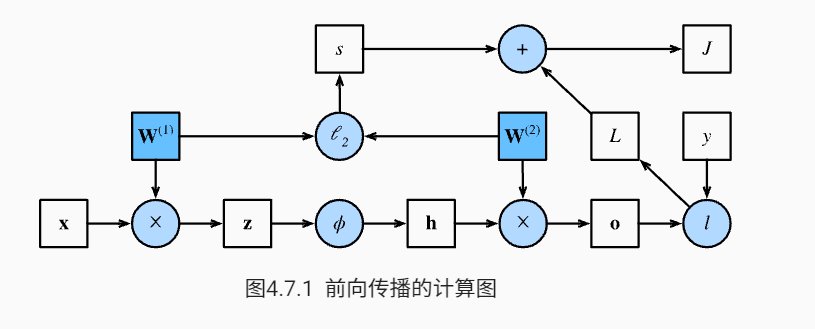

对向量，矩阵求梯度：https://www.cnblogs.com/guosj/p/3569741.html

## 数值稳定性和模型初始化

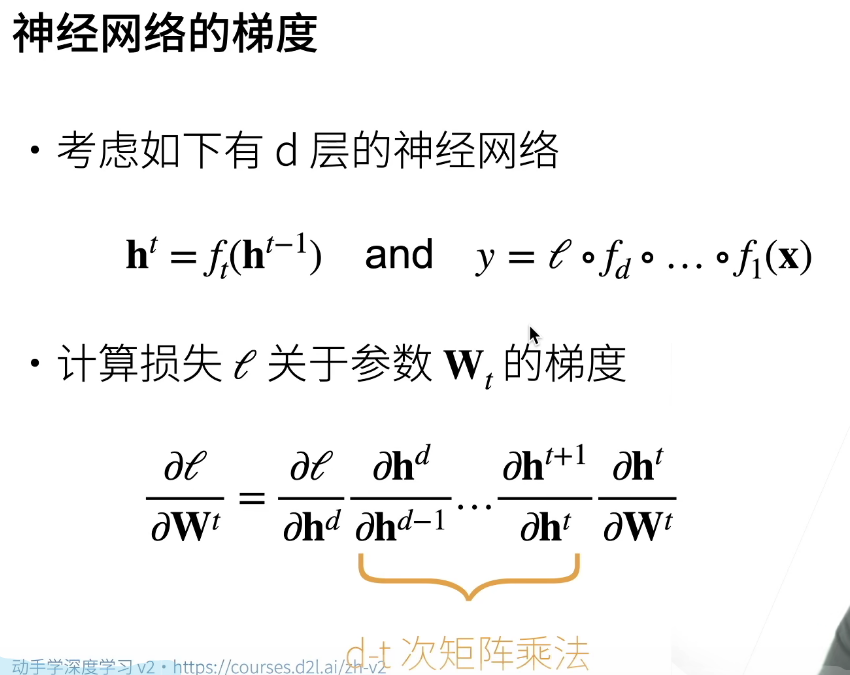

ht是第t层的隐藏层输出。

向量对向量求导是一个矩阵。

### 数值稳定性两个常见的问题

梯度爆炸和梯度消失

- 梯度爆炸：如果梯度是个大于1的数
- 梯度消失：如果梯度是个小于1的数

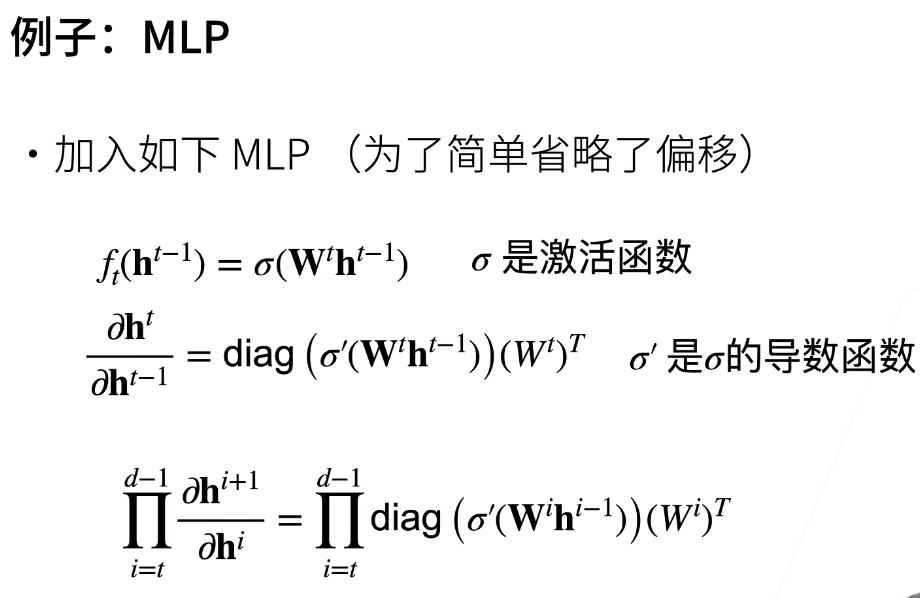

#### 梯度消失

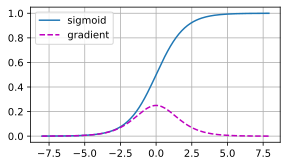

In [50]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(),[y.detach().numpy(),x.grad.numpy()],
        legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

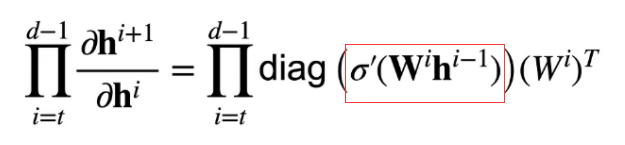

sigmoid的梯度处于0-0.25间，小于1

#### 梯度爆炸

In [53]:
M = torch.normal(0,1,size=(4,4))
print("一个矩阵\n",M)
for i in range(100):  # 100个高斯随机矩阵
    M = torch.mm(M,torch.normal(0,1,size=(4,4)))

print('乘以100个矩阵后\n',M)

一个矩阵
 tensor([[ 1.0951, -0.0680, -1.0548,  0.4659],
        [-0.1419,  0.3704, -1.8075, -0.9774],
        [-1.3791, -0.6872, -0.3862, -0.2300],
        [ 0.2893,  0.5087,  1.5077,  0.0391]])
乘以100个矩阵后
 tensor([[ 2.8940e+20,  1.9364e+21,  3.4368e+20, -5.7159e+20],
        [-9.6264e+20, -6.4087e+21, -1.1544e+21,  1.9062e+21],
        [-1.0103e+21, -6.7512e+21, -1.2030e+21,  1.9969e+21],
        [ 7.8845e+20,  5.2613e+21,  9.4128e+20, -1.5594e+21]])


### 模型初始化和激活函数

#### 让训练更加稳定

- 目标：让梯度值在合理的范围内
    - 乘法变加法，如ResNet,LSTM
    - 归一化，如梯度归一化，梯度裁剪
    - 合理的权重初始和激活函数

#### 让每层的方差是一个常数

- 将每层的输出和梯度都看作随机变量
- 让它们的均值和方差都保持一致

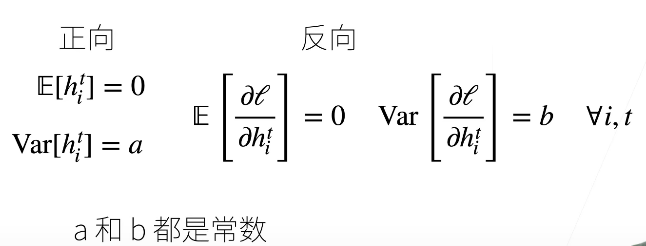

#### 权重初始化

让输出和梯度的均值为零和方差为固定值。

例：MLP

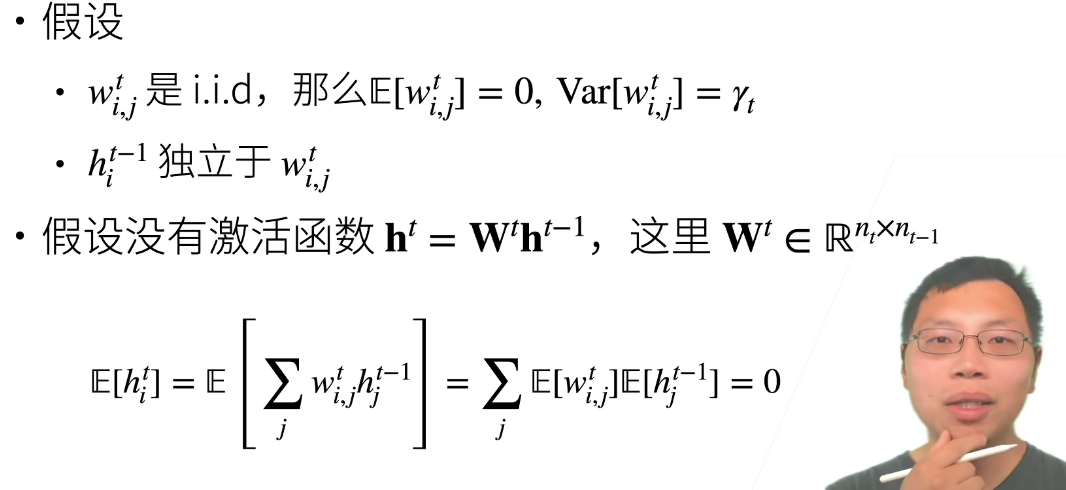

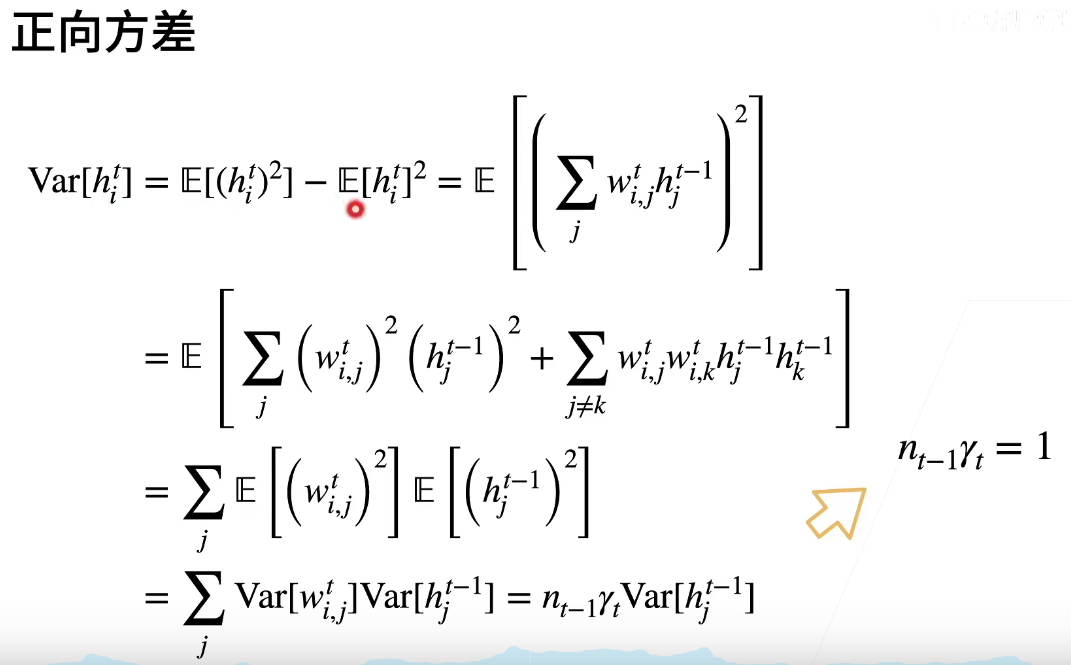

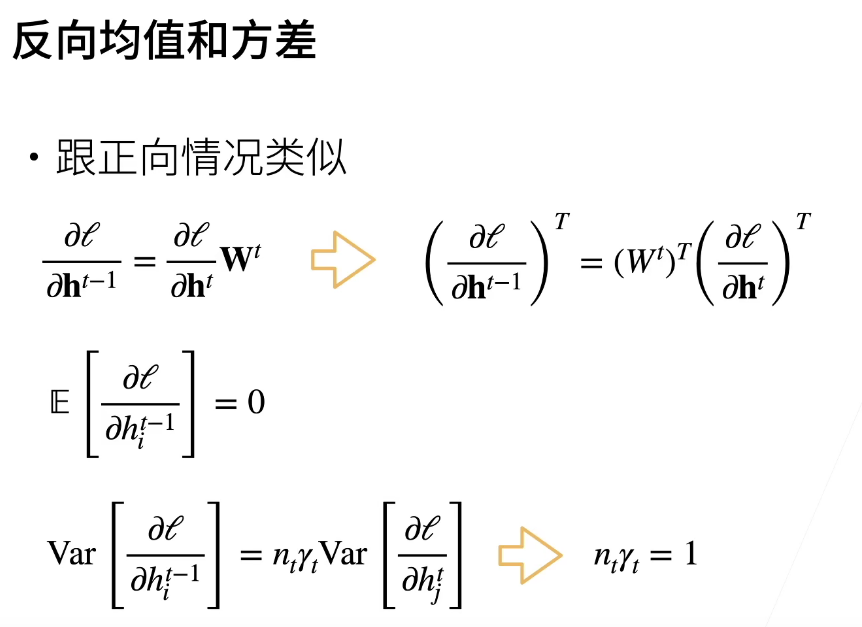

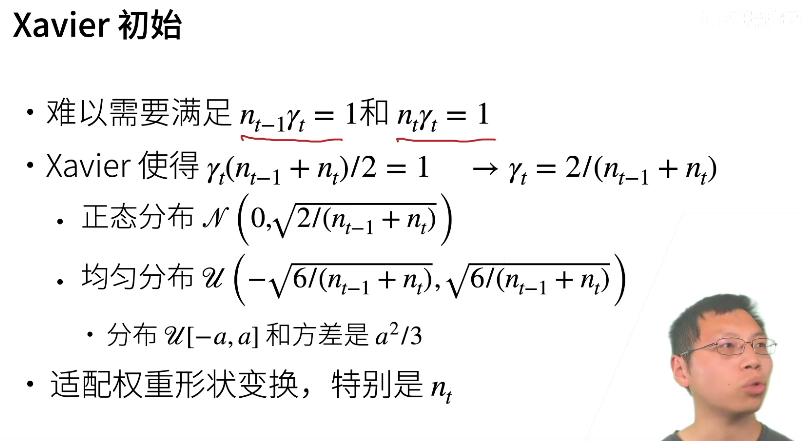

> 通过当前层的输入输出维度可以确定权重初始化。

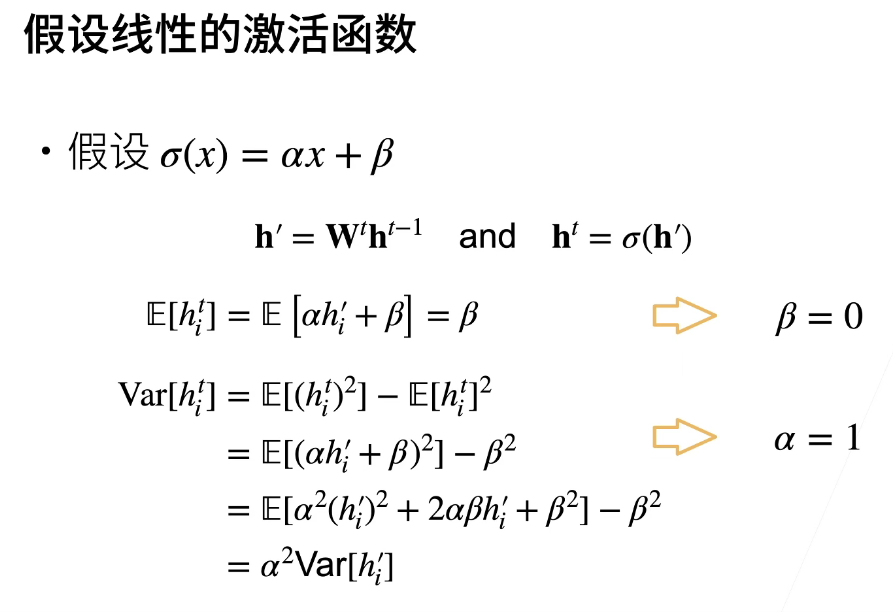

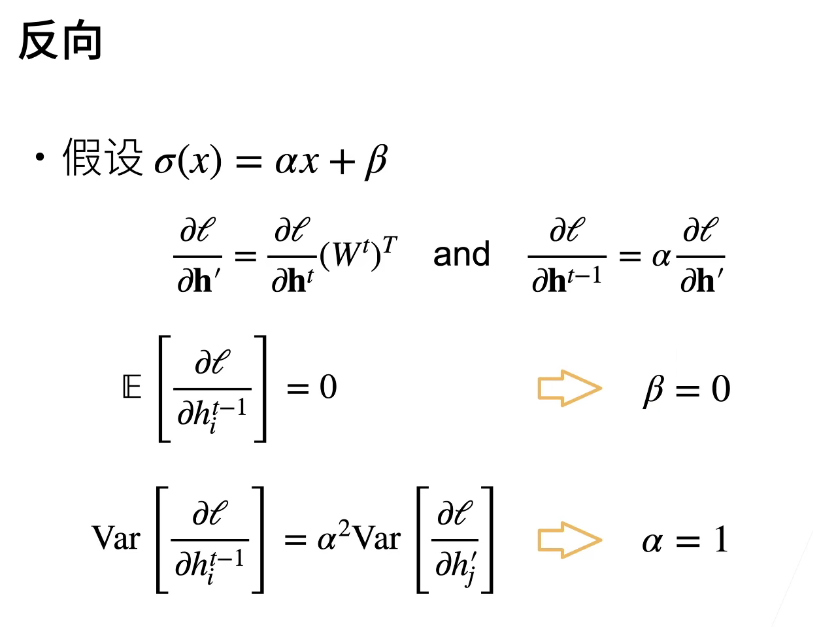

> 上述说明当前仅当激活函数是y=x线性函数才能让训练稳定（保证输出和梯度的均值为0，方差固定）

#### 激活函数选取 

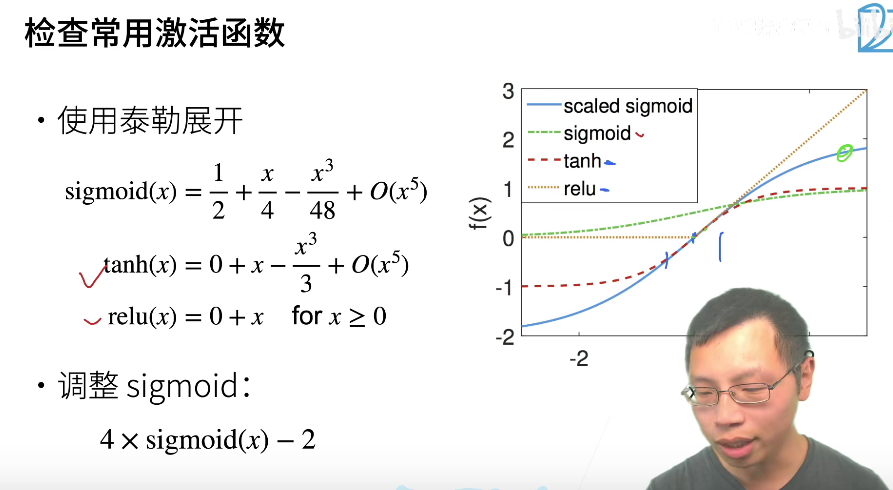

- 泰勒展开：低阶逼近，近似原函数。
- 在x=0处，tanh和relu都是近似为x函数，所以这两个函数作为激活函数是不错的。
- 另外，sigmoid要想作为激活函数，并且效果不错的话，需要调整为上述形式。

## 实战kaggle比赛：预测房价

### 下载和缓存数据集

In [54]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [55]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [56]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [57]:
def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

### kaggle 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

### 访问和读取数据集

In [58]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [59]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [60]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


In [61]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [62]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [63]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 数据预处理

In [64]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # 不是object就是数值特征

In [67]:
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [68]:
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [69]:
# 处理离散值。 这包括诸如“MSZoning”之类的特征。 我们用独热编码替换它们， 方法与前面将多类别标签转换为向量的方式相同。 例如，“MSZoning”包含值“RL”和“Rm”。 我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [70]:
# 转换成tensor格式
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

### 训练

In [72]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [73]:
#我们更关心相对误差 y−y^y ， 而不是绝对误差 y−y^ 
# 对预测值和真实值都做log处理
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [74]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls # 这里的test其实指的验证集

### K 折交叉验证

In [75]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [77]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

### 模型选择

折1，训练log rmse0.170366, 验证log rmse0.157378
折2，训练log rmse0.162444, 验证log rmse0.191621
折3，训练log rmse0.163456, 验证log rmse0.168217
折4，训练log rmse0.168192, 验证log rmse0.154647
折5，训练log rmse0.163442, 验证log rmse0.182905
5-折验证: 平均训练log rmse: 0.165580, 平均验证log rmse: 0.170954


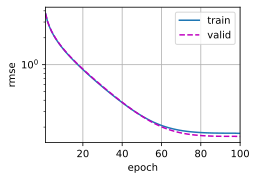

In [78]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

### 提交你的Kaggle预测

In [87]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    # print(preds.shape) # (1459, 1)
    # print(preds.reshape(1, -1).shape) # (1, 1459)
    # print(preds.reshape(1, -1)) # [[119367.72 153963.94 198646.55 ... 208291.31 107010.71 240509.47]]
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162730
(1, 1459)


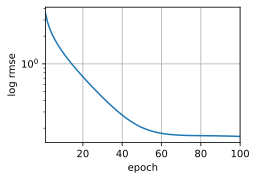

In [88]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)